## Paper-relevant calculations
### and Figure Plotting

In [1]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots
import jax
import warnings 

import imageio

import os

from jax import numpy as jnp
from jax import random
from flax import linen as nn

from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

init_dir = os.getcwd()
warnings.filterwarnings('ignore')

In [2]:
# Load in data dictionary (N, Pa)
dict_name = 'model_data_dictionary_N_Pa.pkl'
data_dict = pickle.load(open(dict_name, 'rb'))
new_dict = data_dict

In [3]:
PSI_to_Pa = 6894.76
lbf_to_N = 4.44822

[1.5, 25.4, nan, nan, nan, nan]


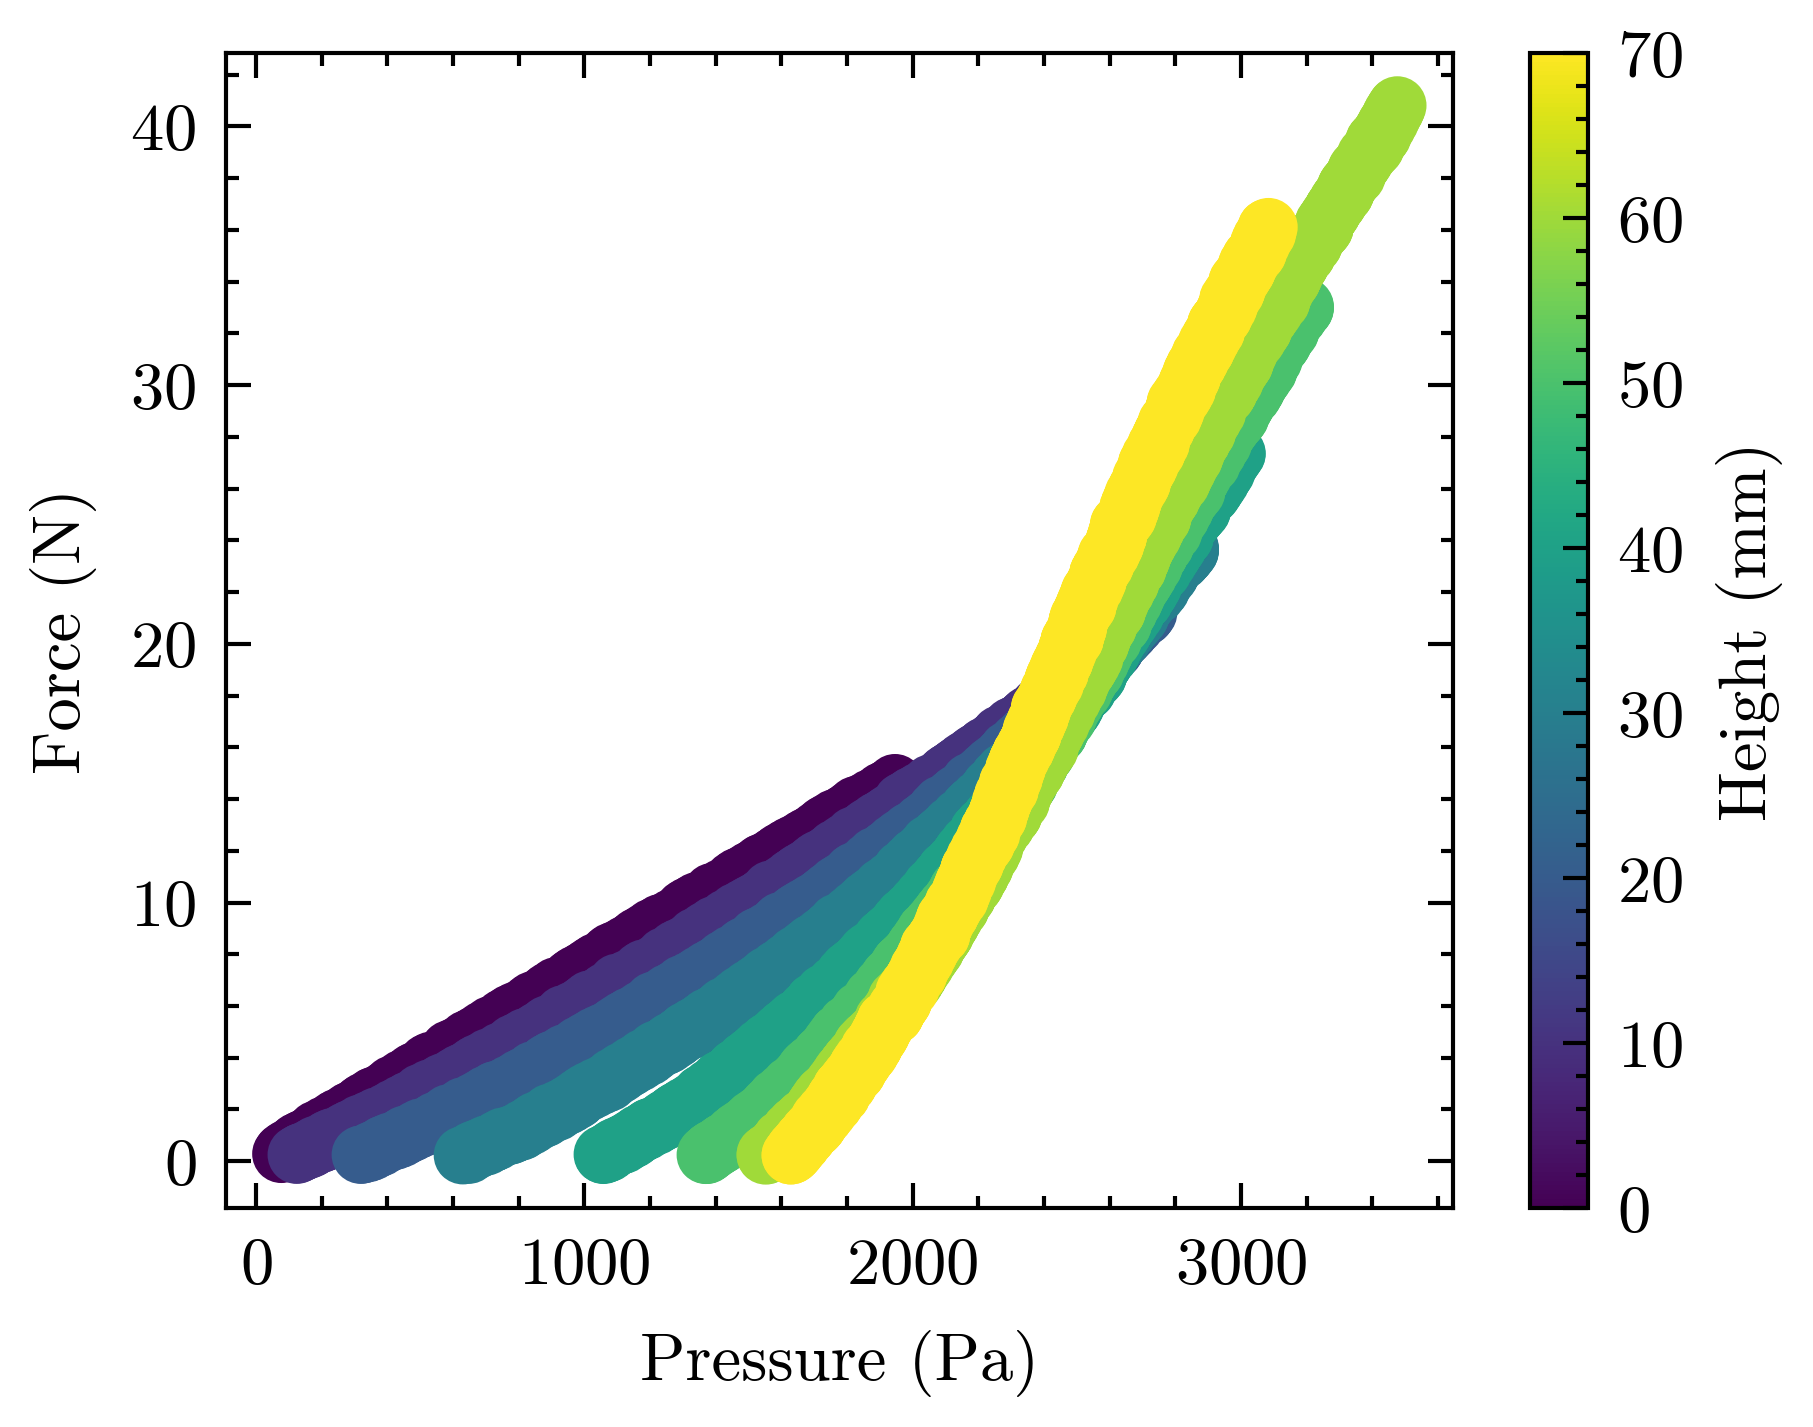

In [4]:
# Example Dataset
i = 2
key = list(new_dict.keys())[i]
print(key)

with plt.style.context(['science','ieee','no-latex']):
    plt.figure()
    height = [x[0] for x in new_dict[key][0][0]]
    pressure = [x for x in new_dict[key][0][1]]
    force = [x for x in new_dict[key][1]]
    plt.scatter(pressure, force, c=height)
    bar = plt.colorbar()
    bar.set_label('Height (mm)')
    plt.xlabel('Pressure (Pa)')
    plt.ylabel('Force (N)')
    plt.show()

In [5]:
# load in TEMPORARY data
all_lift_dict = pickle.load(open('mass_lift_data_dictionary_N_Pa.pkl', 'rb'))

In [6]:
In_mem = [jnp.array([float(x) for x in key[1:-1].split(",")]) for key in all_lift_dict.keys()]

In [7]:
# Checking how each membrane is performing for 'max height'

# Target points:
check_Fs = [[0,1,2],[1,1,1]] # uses indices, as all tests are performed in same mass order (1.5kg, 1.5kg, 2.5kg, 2.5kg, 4kg, 4kg)
check_ps = [jnp.array([1,1,1])*PSI_to_Pa, jnp.array([1.2,1.2,1.2])*PSI_to_Pa]

In [8]:
# heights from relevant points
# data structure taking into account all max heights to solve
mem_performance = jnp.nan*jnp.zeros([len(all_lift_dict), len(check_Fs), len(check_Fs[0])])

# set error tolerance in p
error_tolerance = 0.05 #5%

# for each set of lifts in all_lift_dict
for i in range(len(all_lift_dict)):
    # find the lifts that match check_Fs
    key = list(all_lift_dict.keys())[i]
    this_lift = all_lift_dict[key]
    lift_p = this_lift[0][1][1::2]
    lift_h = this_lift[0][0][:,0][:,None][1::2]
    lift_F = this_lift[1][1::2]
    # for each check_F
    for j in range(len(check_Fs)):
        F_inds = check_Fs[j]
        p_vals = check_ps[j]
        for k, val in enumerate(jnp.unique(lift_F)):
                p = p_vals[k]
                # find the point that matches p most closely
                this_p = lift_p[lift_F == val]
                this_h = lift_h[lift_F == val]
                max_height = jnp.argmax(this_h)
                # this_h = this_h[max_height:] - 154 # 'zero' height in test rig - deprecated.
                # this_h = this_h[max_height:] - min(this_h[max_height:])
                this_h = this_h[max_height:]
                this_p = this_p[max_height:]
                p_ind = jnp.argmin(jnp.abs(this_p-p))
                # record the height
                if (jnp.abs(p - this_p[p_ind]))/p < error_tolerance:
                    mem_performance = mem_performance.at[i,j,k].set(this_h[p_ind])

# print(mem_performance)

In [9]:
# print membrane names
for i in range(len(In_mem)):
    print(In_mem[i])

[ 2.  25.4  nan  nan  nan  nan]
[ 2.  25.4 49.   5.  62.   5. ]
[ 2.33 29.63 37.63  5.   62.    5.  ]
[ 2.   27.98 45.58  5.   60.29  6.71]
[ 2.   38.1  47.55  6.45 62.    5.  ]
[ 2.  25.4 33.4  5.  46.4  5. ]
[ 2.   31.92 46.    5.   59.    5.  ]


Membrane 1: [nan nan nan], [nan nan nan]
Membrane 1: nan, nan
Membrane 2: [75. 72.  7.], [75. nan 64.]
Membrane 2: 6.646177768707275, nan
Membrane 3: [64. 49. 35.], [nan 60. 52.]
Membrane 3: 28.543678283691406, nan
Membrane 4: [56. 43.  4.], [61. 56. 28.]
Membrane 4: 2.4956090450286865, 24.468685150146484
Membrane 5: [43. 42. 29.], [47. 49. 37.]
Membrane 5: 20.07036590576172, 26.88483238220215
Membrane 6: [75. 47. 36.], [75. 50. 44.]
Membrane 6: 29.381927490234375, 35.208831787109375
Membrane 7: [65. 53. 30.], [72. 64. 47.]
Membrane 7: 25.917713165283203, 40.81007385253906


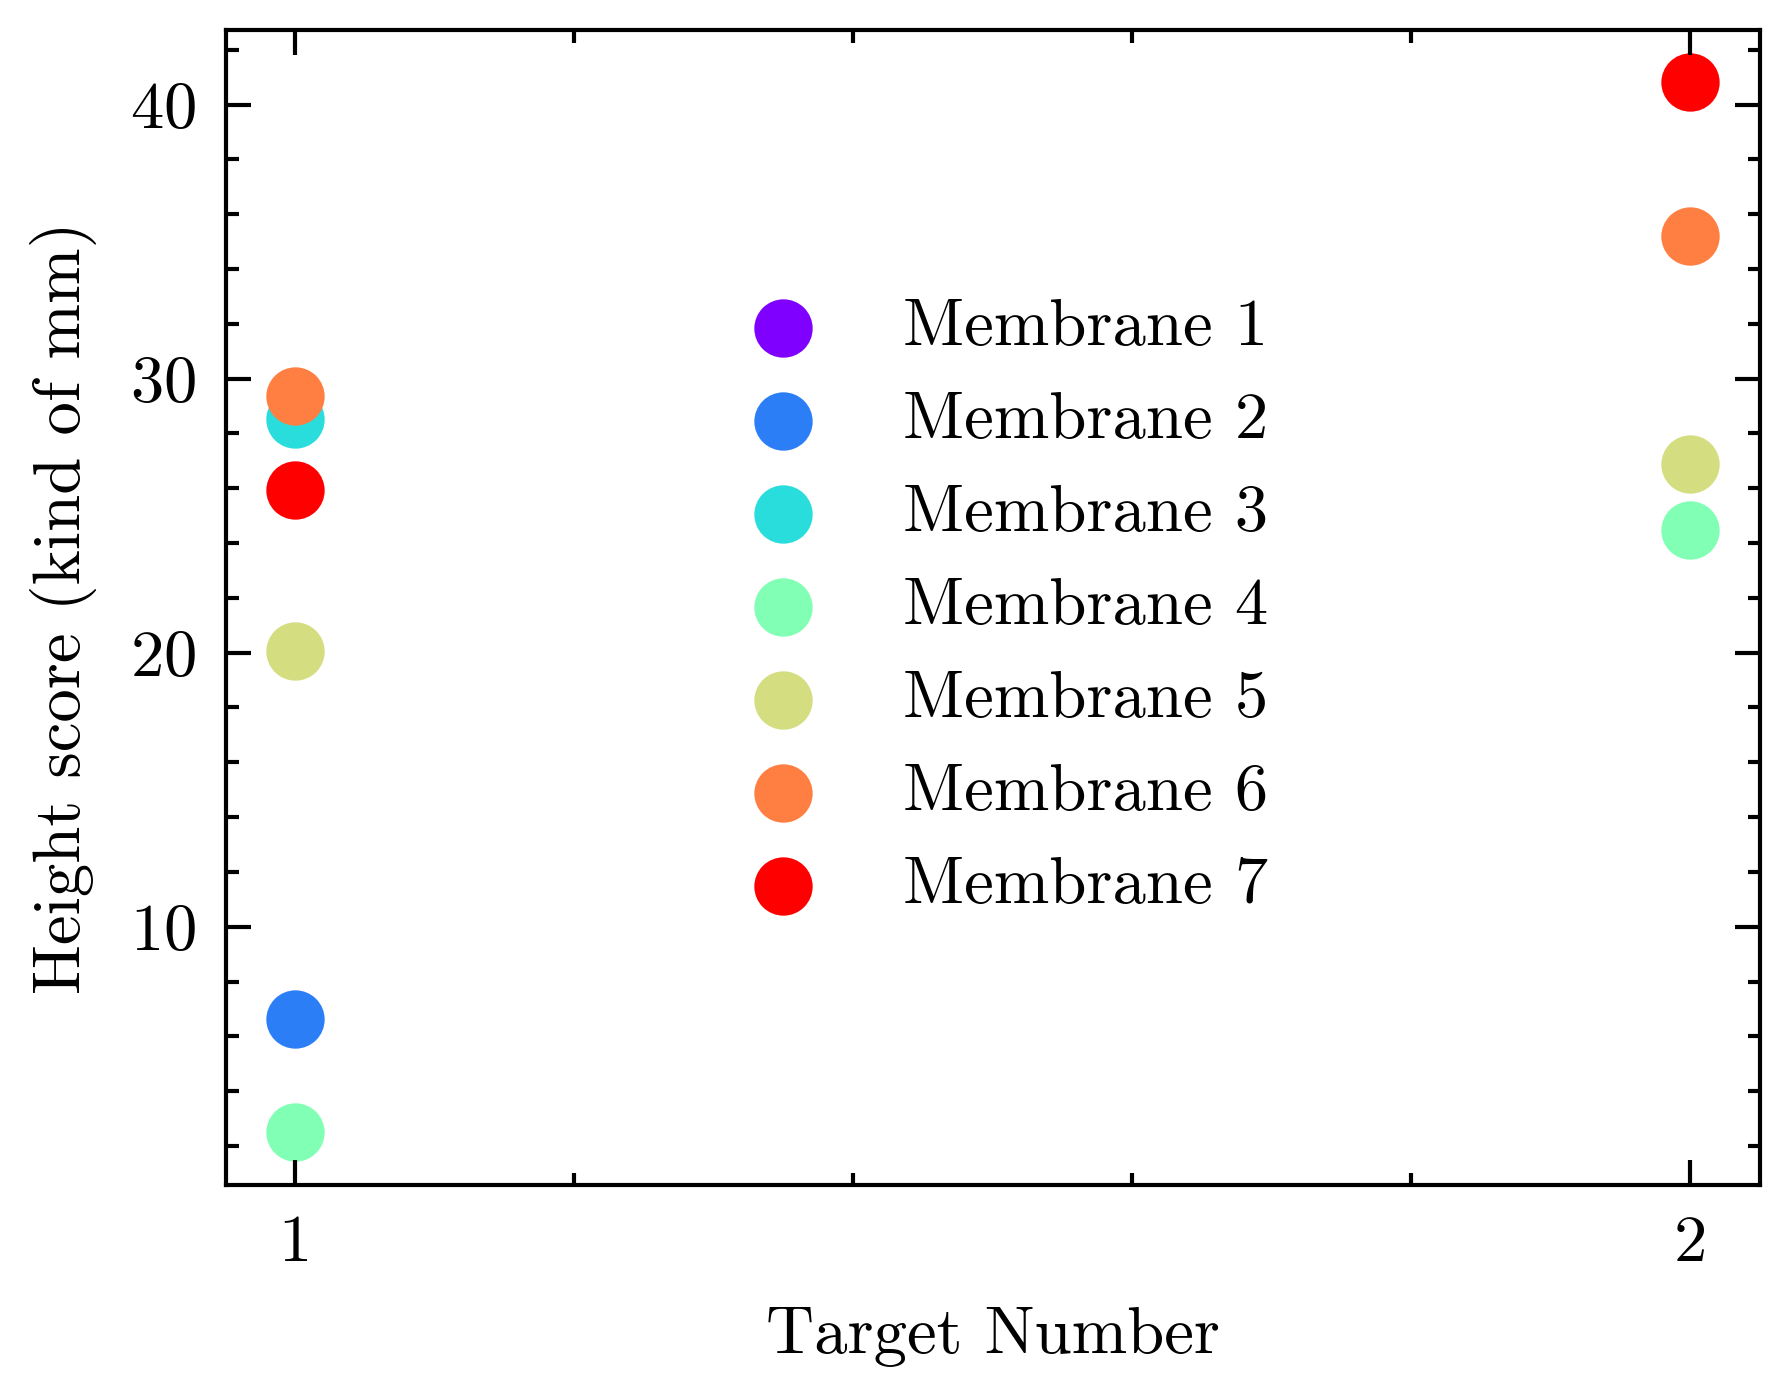

In [10]:
# Membrane performance

# def softmin
def softmin(x, axis = 0, hmax = 80):
    height_factor = (x/hmax) # shape (num_targets,)
    scale = hmax/15 # scalar for scaling logsumexp (a smooth way of computing minimum)
    height_factor = -nn.activation.logsumexp(-height_factor*scale)/scale # scalar
    return height_factor*hmax

score = jnp.zeros([len(mem_performance),2])

# plot membranes performance
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    color = cm.rainbow(jnp.linspace(0, 1, len(mem_performance)))

    for i in range(len(mem_performance)):

        # Min score:
        print(f'Membrane {i+1}: {mem_performance[i][0]}, {mem_performance[i][1]}')
        score1 = softmin(mem_performance[i][0])
        score2 = softmin(mem_performance[i][1])
        # score1 = jnp.mean(mem_performance[i][0])
        # score2 = jnp.mean(mem_performance[i][1])
        score = score.at[i].set([score1, score2])
        print(f'Membrane {i+1}: {score1}, {score2}')
        plt.scatter(1, score1, c = color[i], label = f'Membrane {i+1}')
        plt.scatter(2, score2, c = color[i])

    plt.xlabel('Target Number')
    plt.ylabel('Height score (kind of mm)')
    plt.legend(loc = 'center')
    # xticks only every int
    plt.xticks([1,2], ['1','2'])
    plt.show()

In [11]:
# print(score) # related to mm
print(f'Mem 6 score: {score[5,0]:.1f}')
print(f'Mem 7 score: {score[6,1]:.1f}')
print(f'Alternative membrane mean (4 vals): {jnp.mean(score[1:5][:,0]):.1f}')
print(f'Alternative membrane mean (2 vals): {jnp.mean(score[3:5][:,1]):.1f}')

Mem 6 score: 29.4
Mem 7 score: 40.8
Alternative membrane mean (4 vals): 14.4
Alternative membrane mean (2 vals): 25.7


### Model Training

In [ ]:
# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

In total there are 22 distinct membranes.


In [13]:
for key in data_dict.keys():
    print(key)

[1.0, 25.4, nan, nan, nan, nan]
[1.0, 38.1, nan, nan, nan, nan]
[1.5, 25.4, nan, nan, nan, nan]
[1.5, 38.1, nan, nan, nan, nan]
[2.0, 25.4, nan, nan, nan, nan]
[2.0, 38.1, nan, nan, nan, nan]
[1.0, 25.4, 41.2, 12.8, 62.0, 5.0]
[3.0, 38.1, 49.0, 5.0, 62.0, 5.0]
[3.0, 25.4, 34.73, 6.33, 55.53, 11.47]
[1.0, 25.4, 33.4, 5.0, 46.4, 5.0]
[1.0, 25.4, 33.4, 5.0, 57.05, 9.95]
[1.0, 25.4, 49.0, 5.0, 62.0, 5.0]
[1.0, 38.1, 46.1, 5.0, 59.1, 5.0]
[1.0, 25.4, 37.69, 9.29, 58.49, 8.51]
[1.0, 25.4, 36.06, 7.66, 51.72, 5.0]
[1.0, 25.4, 44.81, 6.65, 60.73, 6.27]
[3.0, 25.4, 40.43, 12.03, 61.23, 5.77]
[3.0, 25.4, 33.4, 5.0, 52.21, 5.0]
[1.6, 25.4, 38.02, 9.62, 62.0, 5.0]
[1.6, 36.6, 46.83, 7.17, 62.0, 5.0]
[2.4, 25.4, 49.0, 5.0, 62.0, 5.0]
[1.0, 25.4, 35.04, 6.26, 50.77, 6.47]


In [14]:
# Define Model
train_data = all_data
identity = lambda x : x

ring_encoder = RingEncoding(24,
                MLP([16,5]),
                na_embeding_init = lambda key, shape, dtype=float : random.uniform(key, shape=shape, dtype=dtype, minval=-jnp.sqrt(3), maxval=jnp.sqrt(3)),
                )
arch = MonotonicActuator(ring_encoder,
                MLP([32,32,32,32], output_activation=nn.gelu),
                polynomial_degree=1)
ensemble_size = 32 
ensemble = RPNEnsemble(arch, ensemble_size)

In [15]:
# train model
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))
# initialize model
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1*lbf_to_N, key=random.key(24)) #start model

Initializing model...


In [16]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [22:01<00:00,  7.57it/s, loss=0.8780039, grad_norm=0.33809102]


In [17]:
def apply_model(membranes, mem_index, h, p, model):
    # takes in a membrane index and applies the model to the membrane configuration
    # returns the force matrix for the membrane configuration (based on set height and pressure ranges)
        # can get away with a minimal height range due to the nature of the target trajectories
    h_len = len(h)
    p_len = len(p)
    # Ensure membrane is a (h_len,6) matrix
    membrane_matrix = jnp.tile(membranes[mem_index], (h.shape[0], 1))
    # Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
    u = jnp.hstack((h, membrane_matrix))
    Fs = jnp.zeros((h_len, p_len)) # units match inpus (N)
    
    # NOTE - could improve speed with vector of h as a matrix, vector of p as a matrix, apply model to all values at once
    for i in range(h_len):
        pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), p)
        pred = nn.relu(pred)
        Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
 
    return Fs

In [18]:
# use the model to predict the force for each membrane in the dataset
# Solve for viable F-p-h data from model for given parameters
num_test = 100

h_num = int(num_test)
p_num = int(num_test)

height_range = jnp.linspace(0, 70, h_num)[:,None] #mm
p_min = 0.01 #Pa
p_max = 10_000 #Pa
pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

flat_Fs = [] #N

for key in new_dict.keys():
    # change key to a membrane input
    key = key[1:-1]
    mem_config = jnp.array([float(x) for x in key.split(', ')])
    # replace nan w/ jnp.nan
    mem_config = jnp.where(jnp.isnan(mem_config), jnp.nan, mem_config)
    # print(f'Using membrane configuration: {mem_config}')

    F1s = apply_model([mem_config],0,height_range,pressures, model)
    F_model = F1s.flatten() # N
    flat_Fs.append(F_model)

# Repeat the pressures for each height by tiling
p_model = jnp.tile(pressures, h_num).flatten('F') # Pa

# Tile the heights for each pressure
h_model = jnp.repeat(height_range, len(pressures)) #mm

print(f'Predicted {len(flat_Fs)} membranes forces')


Predicted 22 membranes forces


In [19]:
# repeat force calculation for test-set membranes
test_Fs = [] #N

for key in all_lift_dict.keys():
    # change key to a membrane input
    key = key[1:-1]
    mem_config = jnp.array([float(x) for x in key.split(', ')])
    mem_config = jnp.where(jnp.isnan(mem_config), jnp.nan, mem_config)

    F1s = apply_model([mem_config],0,height_range,pressures, model)
    F_model = F1s.flatten() # N
    test_Fs.append(F_model)

print(f'Predicted {len(test_Fs)} membranes forces')


Predicted 7 membranes forces


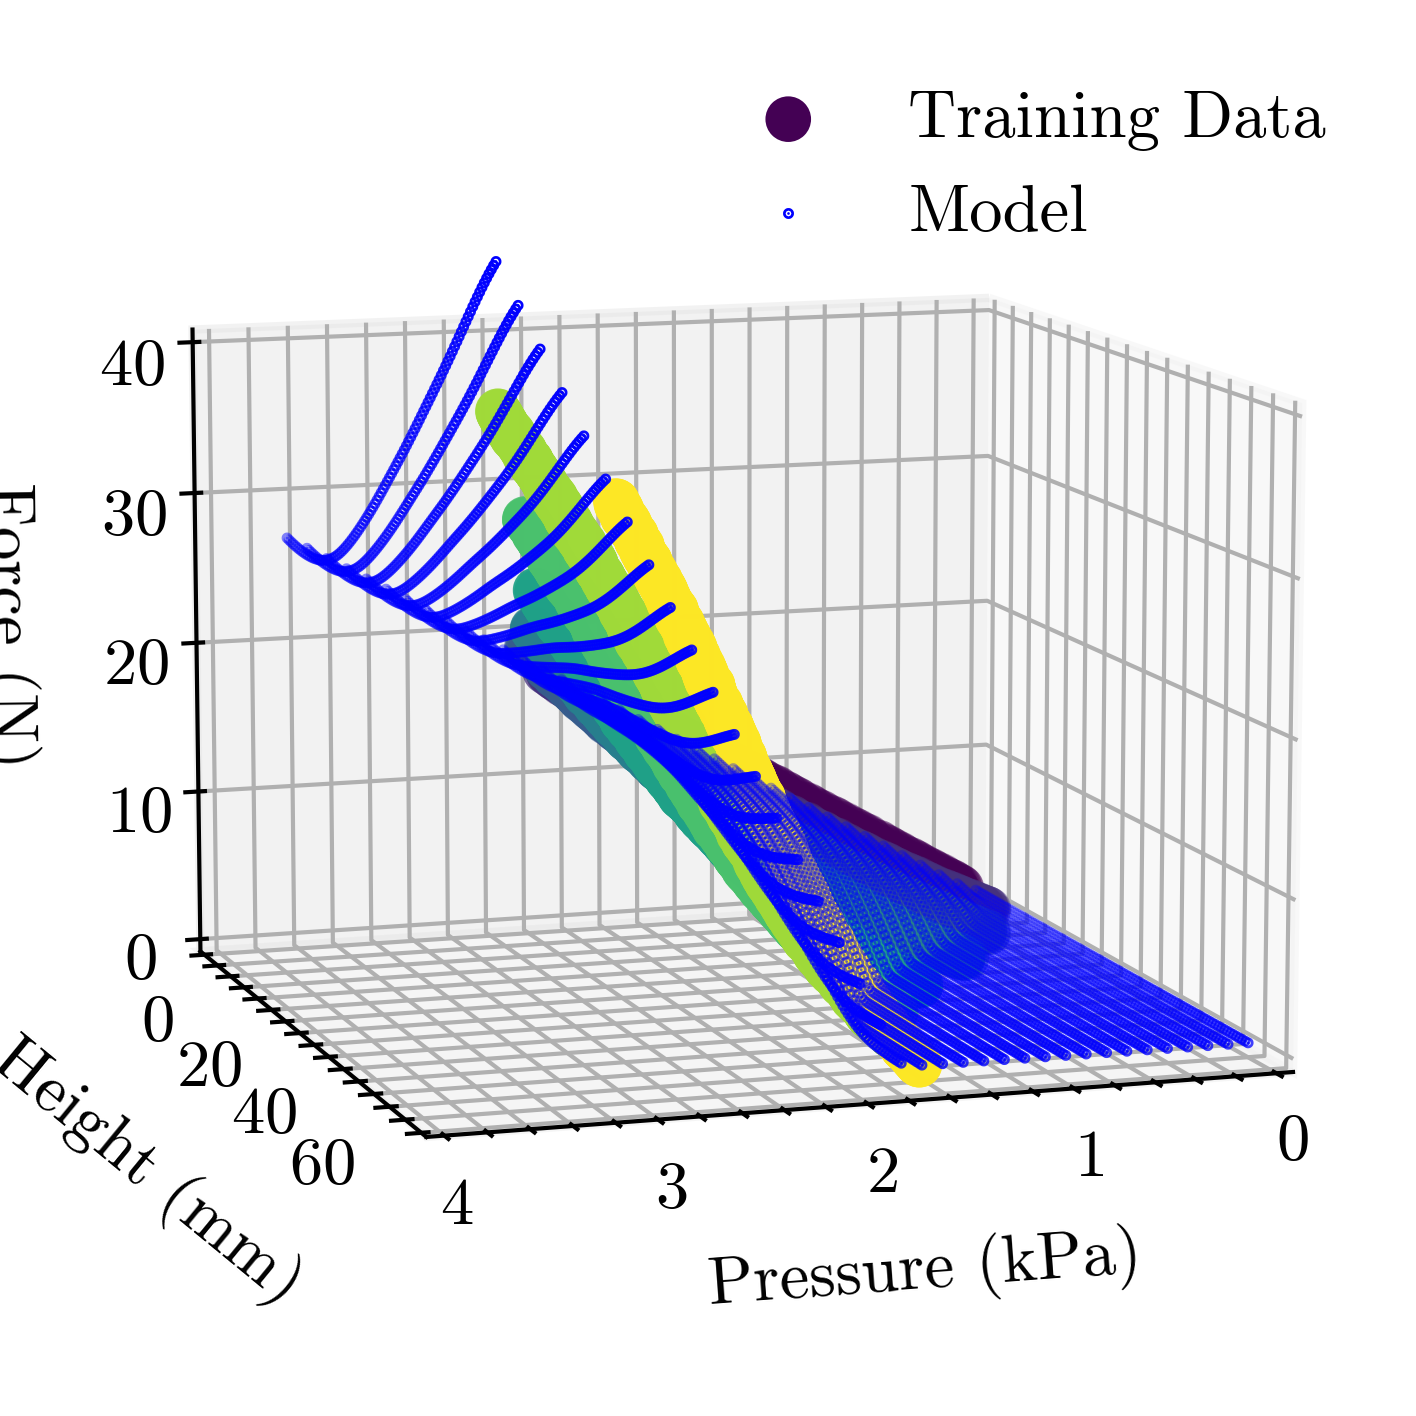

In [20]:
# choose an example membrane to plot
j = 2
trim = 37 # contain data to z-limits of training data 
key = list(new_dict.keys())[j]
height = jnp.array([x[0] for x in new_dict[key][0][0]])
pressure = jnp.array([x[0] for x in new_dict[key][0][1]])
force = jnp.array([x[0] for x in new_dict[key][1]])

trim_p = jnp.concatenate([p_model[100*i:100*i+trim] for i in range(100)])
trim_h = jnp.concatenate([h_model[100*i:100*i+trim] for i in range(100)])
trim_F = jnp.concatenate([flat_Fs[j][100*i:100*i+trim] for i in range(100)])

with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pressure/1000, height, force, c=height, marker='o')
    # ax.scatter(p_model[:trim], h_model[:trim], flat_Fs[j][:trim], s=0.1, c='b', marker='o')
    ax.scatter(trim_p/1000, trim_h, trim_F, s=0.1, c='b', marker='o')


    # change the view angle
    # ax.view_init(elev=10, azim=-30)
    ax.view_init(elev=10, azim=72)
    # set axis limits based on pressure, height, force
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 75])
    # ax.set_ylim([60, 0])
    ax.set_zlim([0, 40])
    # tighten up to axis
    pad = -5
    ax.tick_params(axis='x', pad=pad+1)
    ax.tick_params(axis='y', pad=pad+2)
    ax.tick_params(axis='z', pad=pad+2)
    ax.set_xlabel('Pressure (kPa)', labelpad=pad)
    ax.set_ylabel('Height (mm)', labelpad=pad)
    ax.set_zlabel('Force (N)', labelpad=pad)
    plt.tight_layout()
    plt.legend(['Training Data', 'Model'], loc='upper right')
    plt.savefig('Model_vs_Training.png')
    plt.show()


## TODO - There may be a bug in 'p_on_plane' ?? (More likely in the model itself.)

In [21]:
"""
p on plane - use known p instead of random (i.e. to test other functions)
takes:
    test_h - target height values (n,m)
    test_F - target force values (n,) [N]
    p_min - minimum pressure value [PSI]
    p_max - maximum pressure value [PSI]
    p_num - number of pressure values to generate
    membranes - list of all membrane configurations
    model - jax ML model
    solution - index of the membrane configuration to apply the model to
    seed_vals - seed value for random number generator
returns:
    pressures - known nxn matrix of target pressures [PSI]

"""
def p_on_plane(test_h, test_F, p_min, p_max, p_num, membranes, model, solution, seed_vals = [894]):
    key1, key2, key3, key4 = random.split(random.PRNGKey(seed_vals[0]), 4)
    n = len(test_F)
    m = len(test_h[0])

    # solve min and max pressures for each force/height pair
    heights = jnp.array(test_h)
    forces = [i for i in test_F]
    pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

    min_p1 = jnp.array(jnp.max(pressures)) * jnp.ones(heights.shape)
    max_p1 = jnp.array(jnp.min(pressures)) * jnp.ones(heights.shape)
    # use the old code for multiple pressures for a single height - find closest force.
    # create a line for each target-f, target-h pair and all possible values of pressure
    for i in range(n):
        for j in range(m):
            k = solution
            Fs = apply_model(membranes, k, jnp.array([heights[i][j]]).reshape(-1, 1), jnp.linspace(p_min, p_max, p_num)[:,None], model)
            Fs = Fs.flatten()
            error = jnp.abs(Fs - forces[i])
            min_error = jnp.min(error)
            min_index = jnp.argmin(error)
            closest_p = pressures[min_index]
            # print([min_p[i][j], closest_p])
            # print(jnp.min(jnp.hstack([min_p[i][j], closest_p])))
            min_p1 = min_p1.at[i, j].set(jnp.min(jnp.hstack([min_p1[i, j], closest_p])))
            max_p1 = max_p1.at[i, j].set(jnp.max(jnp.hstack([max_p1[i, j], closest_p])))

    matching_p = random.uniform(key4, (n,m), minval=min_p1, maxval=max_p1)
    # pressures11 = jnp.sort(pressures1, axis=1)
    return matching_p

In [22]:
# Target points for each test membrane - this is how it was calculated in the past, yet no longer seems to get the job done.
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences
test_F = [14.715, 24.525, 39.24]

target_ps_off = []
for solution in range(len(In_mem)-2):
    test_p = p_on_plane(test_h, test_F, p_min, p_max, p_num, In_mem, model, solution)
    target_ps_off.append(test_p)

target_ps_off = jnp.array(target_ps_off)
print('Target pressures (Pa) for each membrane:')
for i in range(len(target_ps_off)):
    print(f'Membrane {i+1}: {target_ps_off[i]} Pa')

Target pressures (Pa) for each membrane:
Membrane 1: [[2121.22   2727.28   2828.2898]
 [3434.35   3333.3398 3333.3398]
 [5353.54   4242.43   4141.42  ]] Pa
Membrane 2: [[2727.28   4040.41   4747.48  ]
 [4343.4404 5454.55   5959.6   ]
 [6868.69   7474.75   7878.79  ]] Pa
Membrane 3: [[2121.22   4747.48   6060.61  ]
 [3333.3398 6060.61   7575.7603]
 [5151.52   8080.81   9797.9795]] Pa
Membrane 4: [[2424.25   4444.4497 5454.55  ]
 [3939.4001 5858.59   6969.6997]
 [6161.62   8080.81   9090.91  ]] Pa
Membrane 5: [[ 1818.1901  5353.54    7474.75  ]
 [ 2828.2898  6767.68    9393.94  ]
 [ 4343.4404  8888.89   10000.    ]] Pa


In [23]:
# 'Magic' target points (these were calculated from models at some point in the past...)
# Current models don't calculate these values, so they can be considered arbitrary targets

membrane_data = [
    [[0.3114, 0.4078, 0.4204], [0.4873, 0.4971, 0.4935], [0.7279, 0.6131, 0.5937]],  # Membrane 1
    [[0.3952, 0.5817, 0.6834], [0.6478, 0.7839, 0.8618], [1.0586, 1.0654, 1.1054]],  # Membrane 2
    [[0.3156, 0.7035, 0.8847], [0.4988, 0.8856, 1.0768], [0.7721, 1.1348, 1.3457]],  # Membrane 3
    [[0.3481, 0.6786, 0.8455], [0.5708, 0.887, 1.048], [0.9253, 1.1788, 1.3317]],    # Membrane 4
    [[0.2647, 0.787, 1.0816], [0.4162, 0.9783, 1.3448], [0.6402, 1.2499, 1.5]]       # Membrane 5
]

target_ps = jnp.array(membrane_data)*PSI_to_Pa

In [24]:
target_ps - target_ps_off

Array([[[  25.808105 ,   84.40283  ,   70.26709  ],
        [ -74.53369  ,   94.045166 ,   69.22412  ],
        [-334.84424  ,  -15.25293  ,  -48.00122  ]],

       [[  -2.4709473,  -29.728027 ,  -35.601562 ],
        [ 122.98535  ,  -49.74756  ,  -17.6958   ],
        [ 430.10254  , -129.07275  , -257.32275  ]],

       [[  54.766357 ,  102.9834   ,   39.184082 ],
        [ 105.76636  ,   45.38916  , -151.48291  ],
        [ 171.92383  , -256.6372   , -519.7012   ]],

       [[ -24.184082 ,  234.33447  ,  374.96973  ],
        [  -3.871338 ,  257.062    ,  256.0083   ],
        [ 218.10107  ,   46.73242  ,   90.84082  ]],

       [[   6.852783 ,   72.63574  ,  -17.378418 ],
        [  41.309326 ,  -22.53711  , -121.86719  ],
        [  70.58496  , -271.12988  ,  342.13965  ]]], dtype=float32)

In [25]:
jnp.array([[i]*3 for i in test_F]).flatten()

Array([14.715, 14.715, 14.715, 24.525, 24.525, 24.525, 39.24 , 39.24 ,
       39.24 ], dtype=float32)

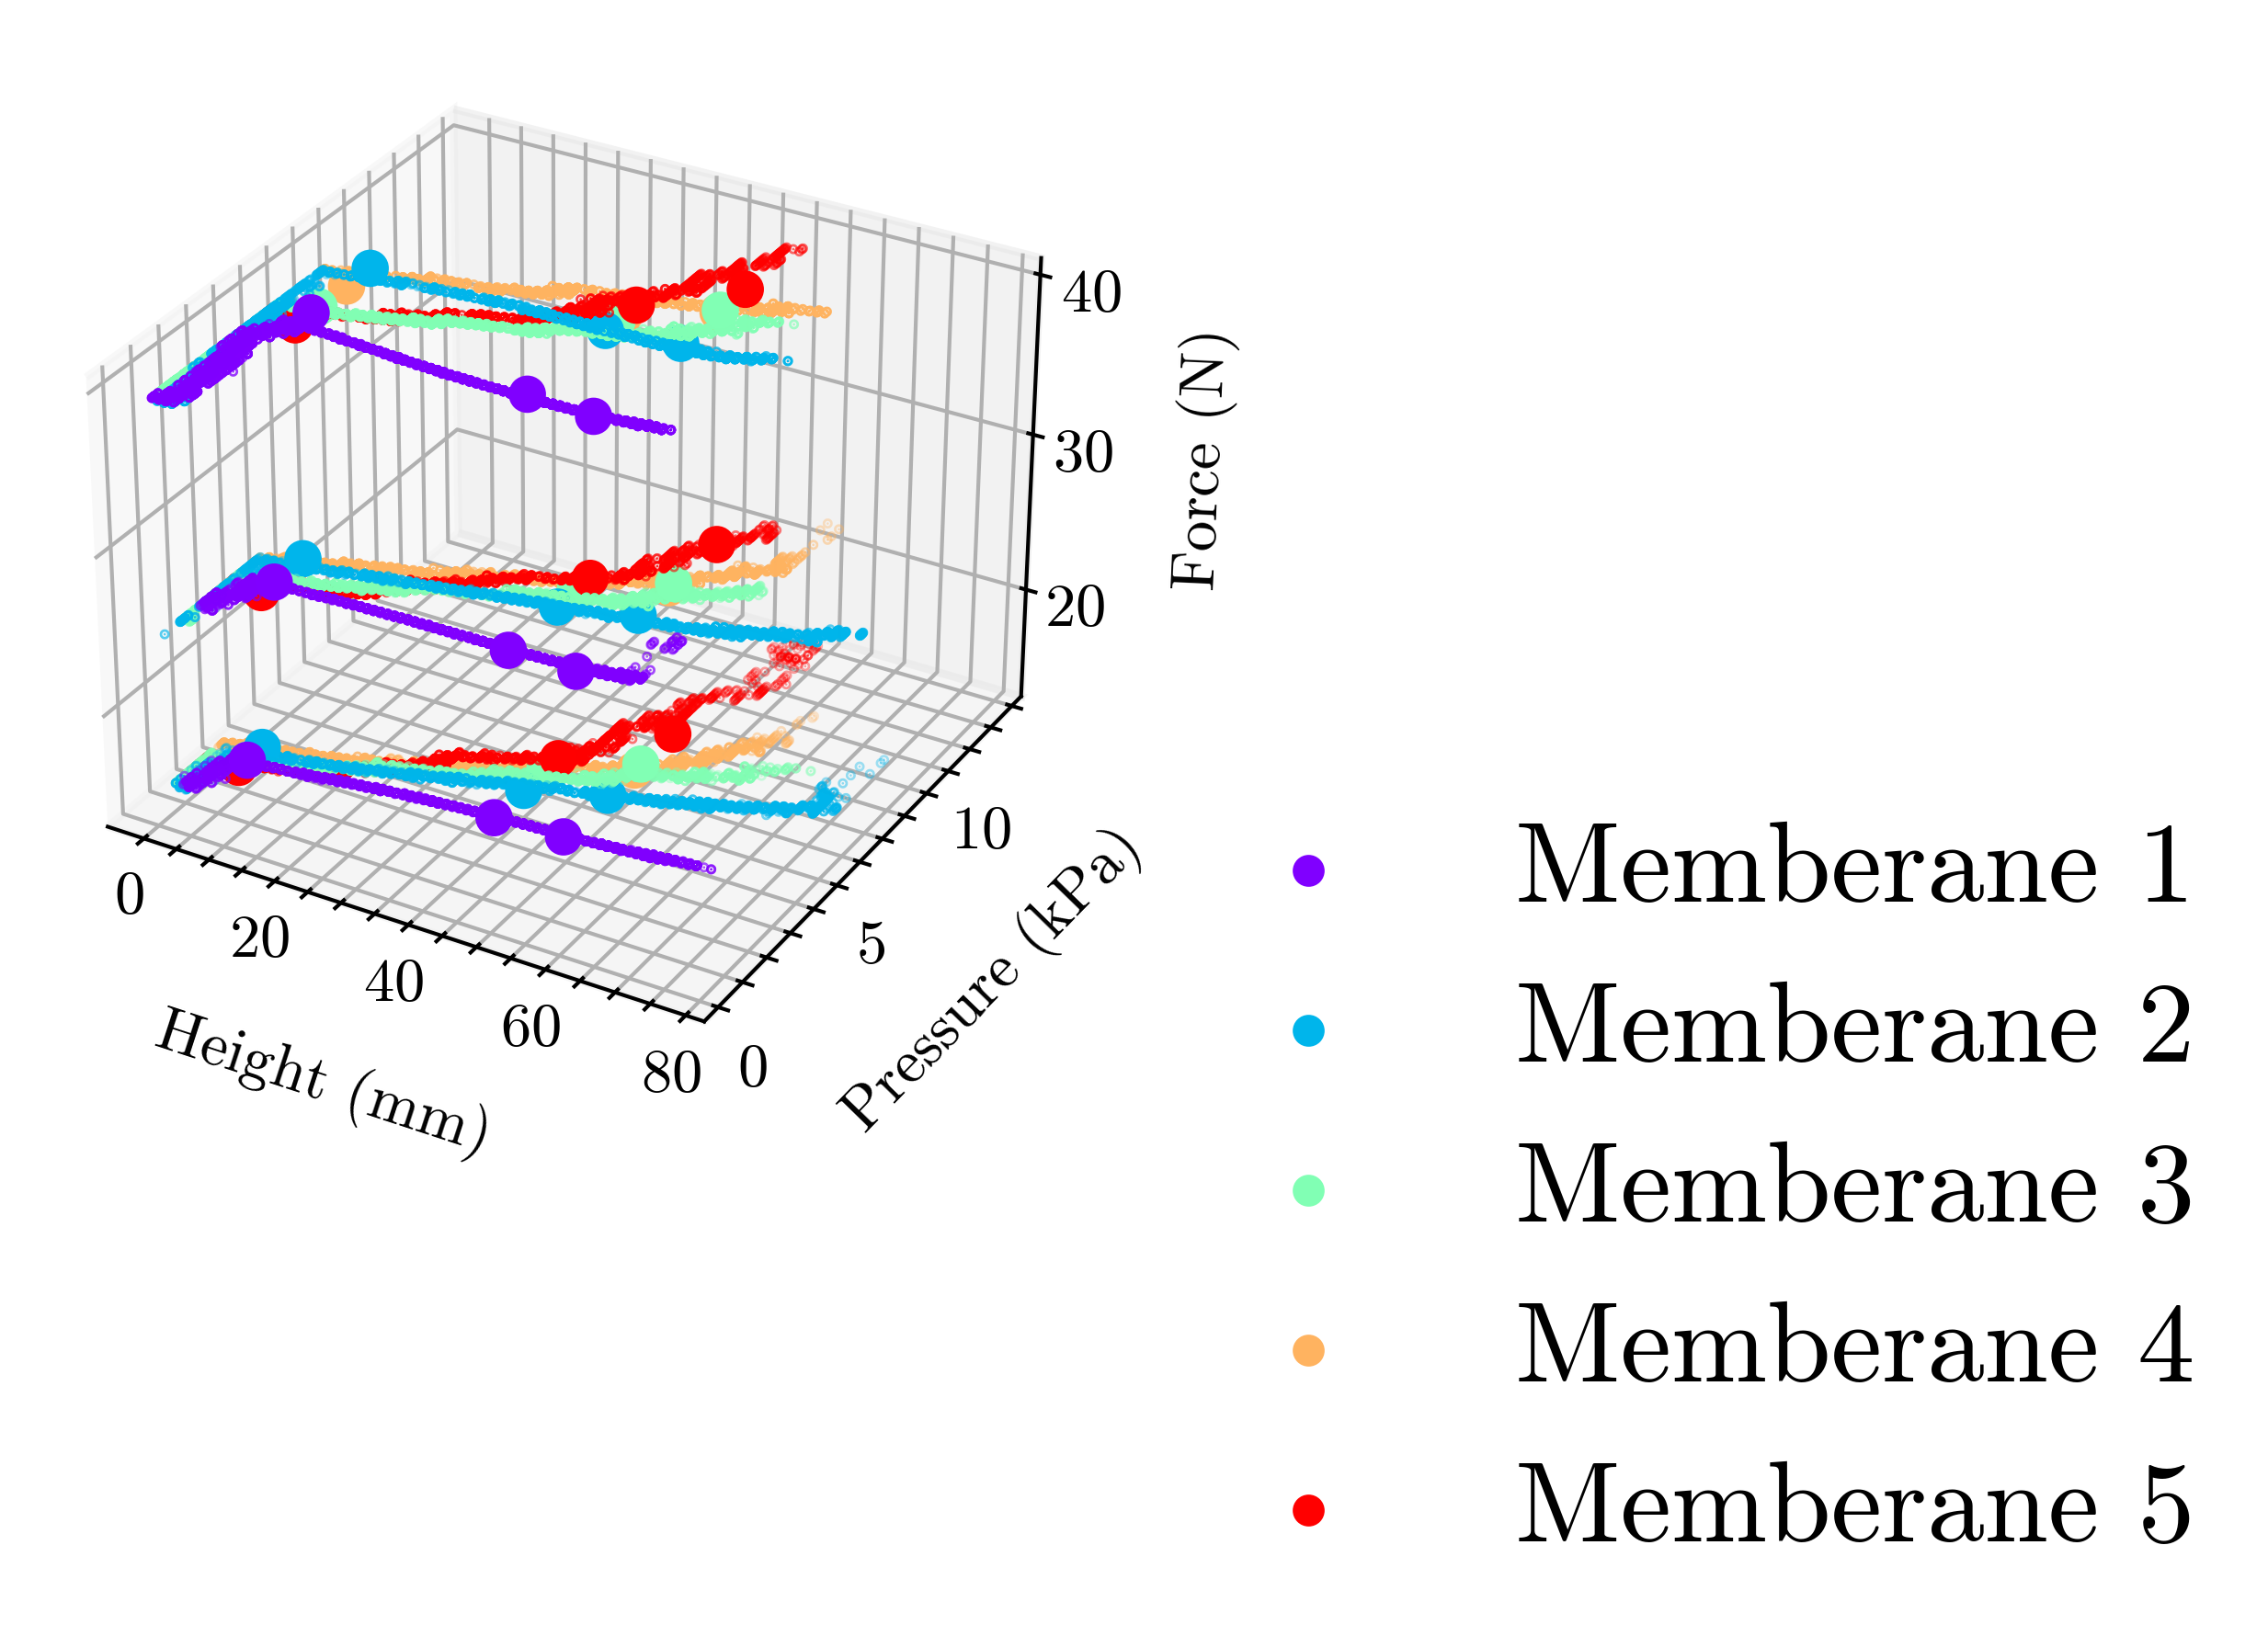

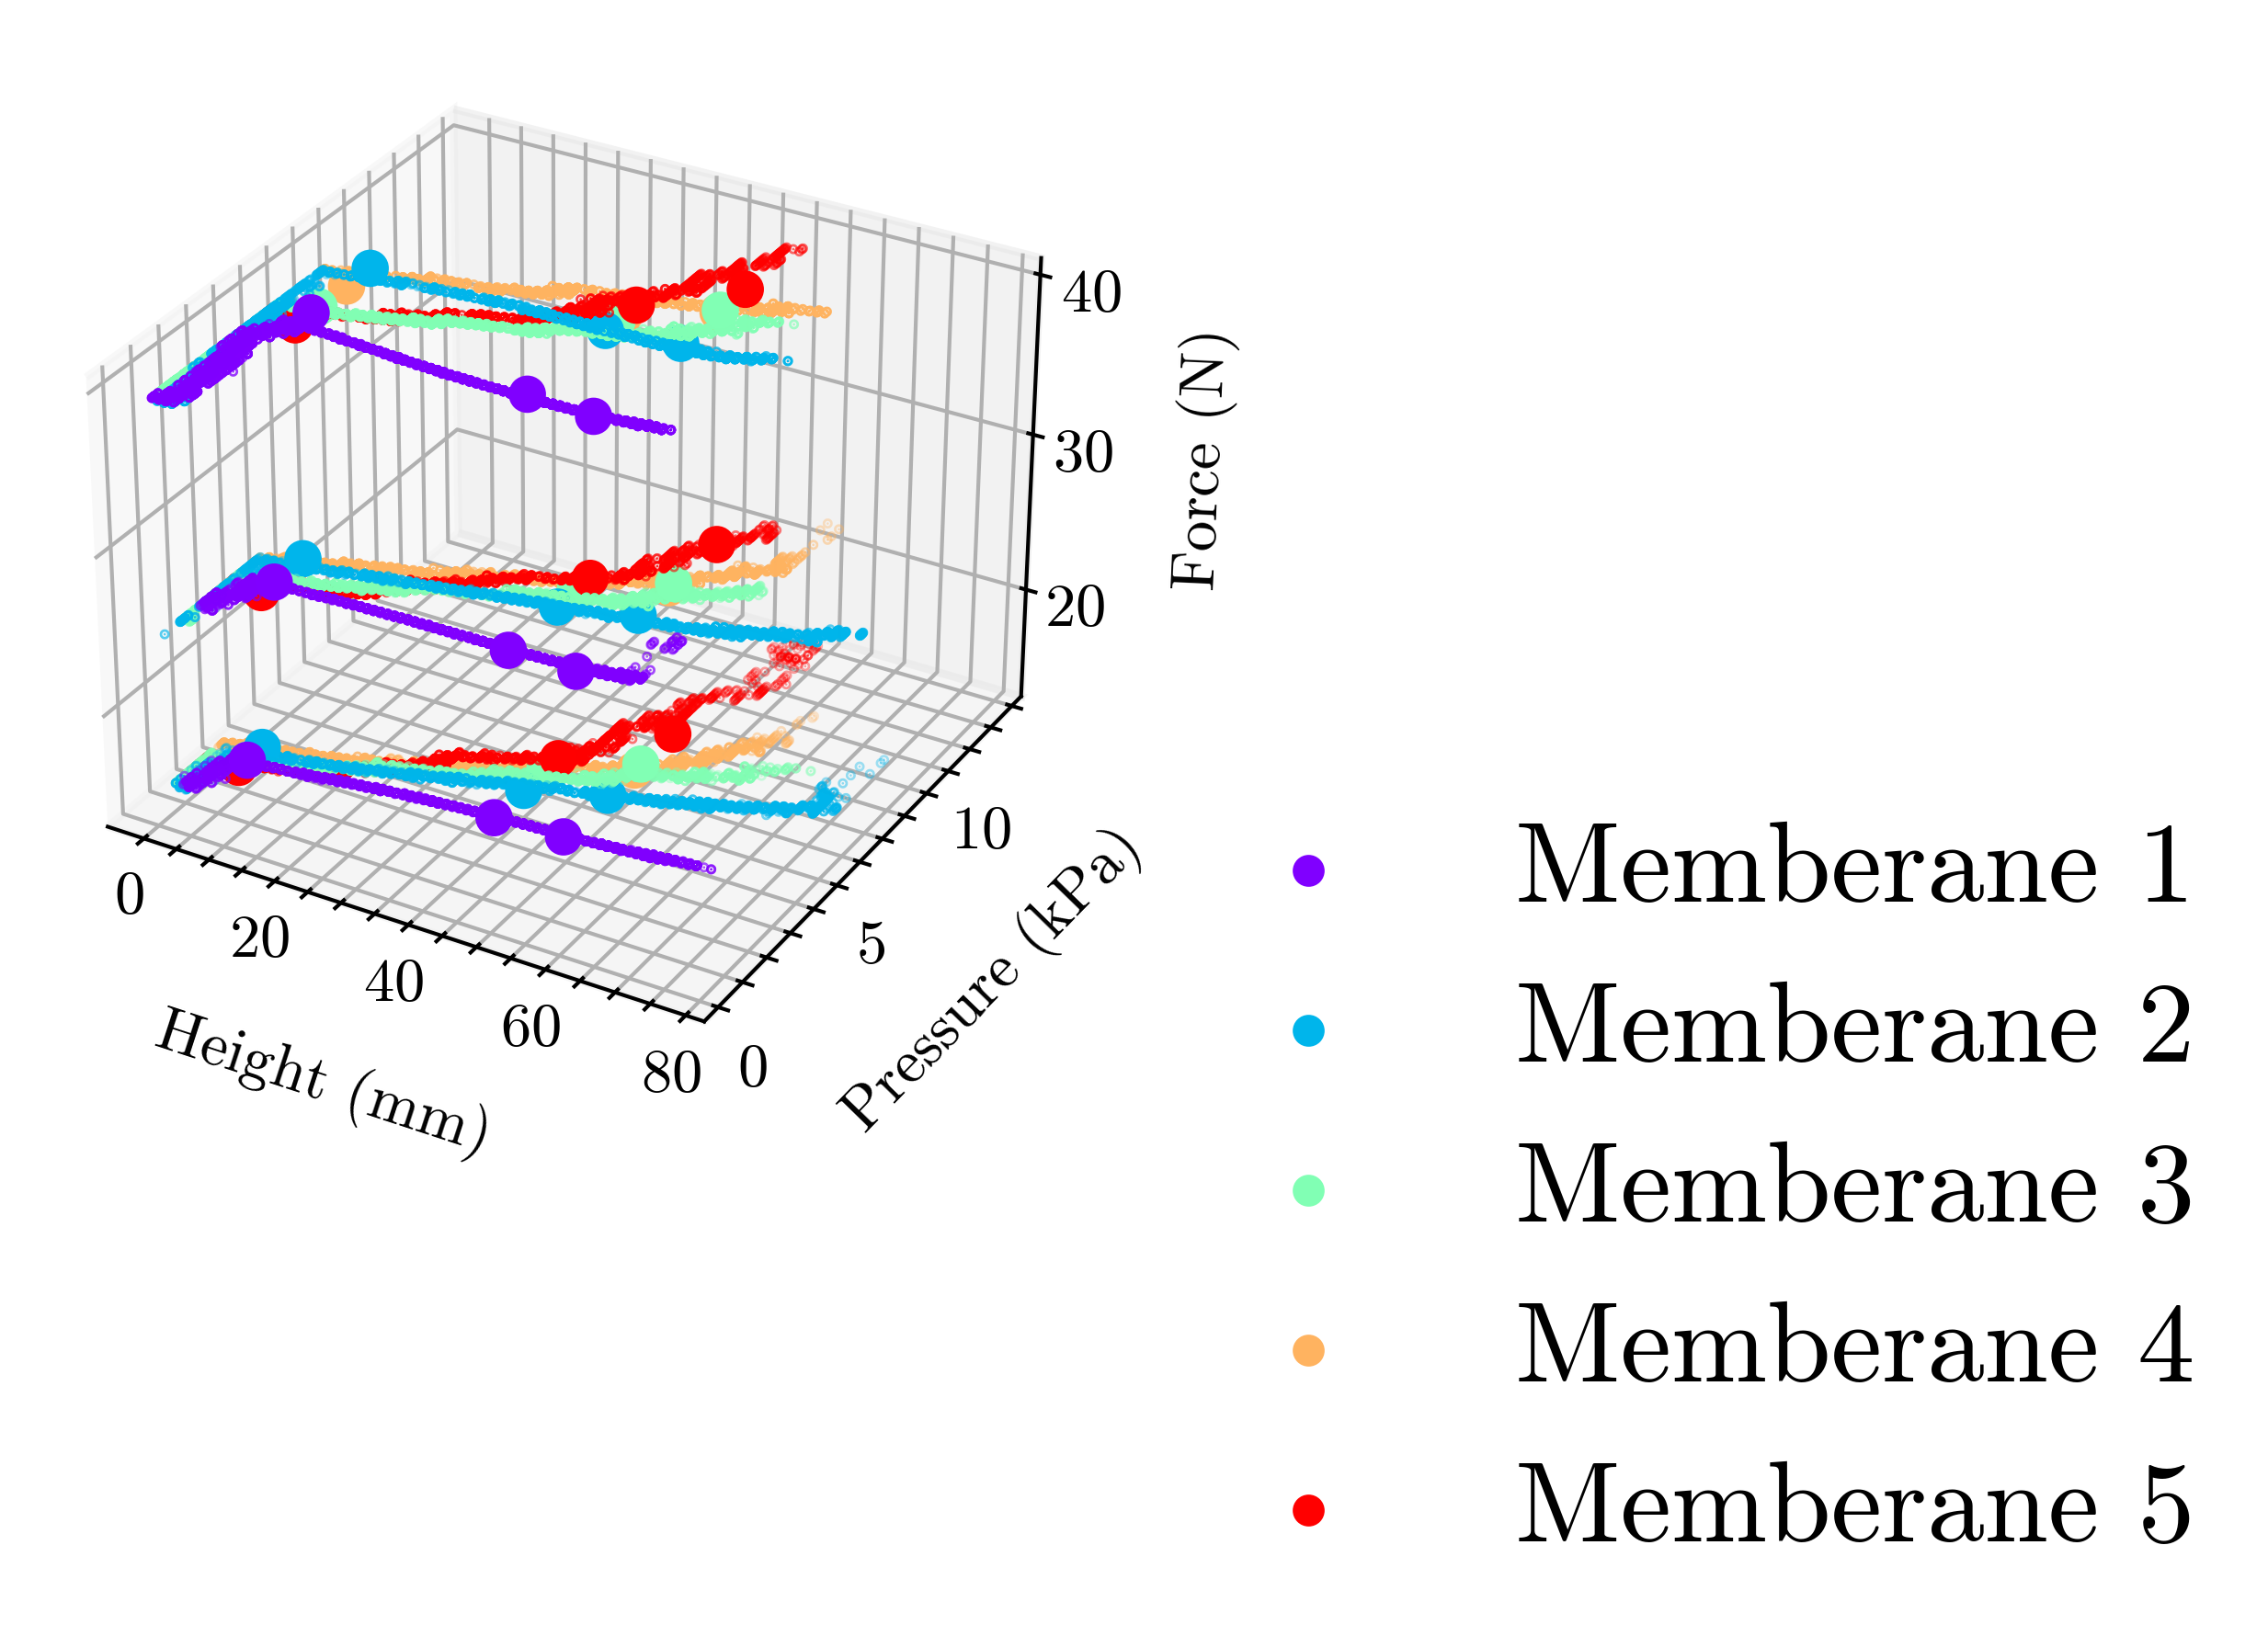

In [26]:
# plot target points and lift trajectories
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = plt.subplot(111, projection='3d')
    colors = cm.rainbow(jnp.linspace(0, 1, len(In_mem)-2))

    keys = list(all_lift_dict.keys())

    for i in range(len(In_mem)-2):
        # pull all exp data into one list
        exp_heights = []
        exp_pressures = []
        exp_forces = []

        # go through entry in lift_df
        data_in = all_lift_dict[keys[i]]
        exp_heights = data_in[0][0][:,0][:,None]
        exp_pressures = data_in[0][1][:,0][:,None]
        exp_forces = data_in[1][:,0][:,None]

        ax.scatter(exp_heights, exp_pressures/1000, exp_forces, c=colors[i], s=0.1, label=f'Memberane {i+1}')

        # scatter the target points as well
        targ_h = test_h.flatten()
        targ_p = target_ps[i].flatten()/1000
        targ_F = jnp.array([[i]*3 for i in test_F]).flatten()
        
        ax.scatter(targ_h, targ_p, targ_F, s=15, c=colors[i], alpha=1)

    # increase label size
    plt.rcParams.update({'axes.labelsize': 15})
    plt.rcParams.update({'legend.fontsize': 15})

    # ax.set_xlabel('Height (mm)')
    # ax.set_ylabel('Pressure (kPa)')
    # ax.set_zlabel('Force (N)')
    plt.legend(markerscale=10, loc='upper left', bbox_to_anchor=(1, 0.35))
    pad = -5
    ax.tick_params(axis='x', pad=pad)
    ax.tick_params(axis='y', pad=pad+1)
    ax.tick_params(axis='z', pad=pad+1)
    ax.set_xlabel('Height (mm)', labelpad=pad-1)
    ax.set_ylabel('Pressure (kPa)', labelpad=pad-1)
    ax.set_zlabel('Force (N)', labelpad=pad-2)

    # plt.legend(markerscale=10, loc='upper right')
    plt.show()
    # frames = plot_spin([ax], save=False)



In [ ]:
# Solve max height across all test membranes
max_heights = []
for mem in range(len(In_mem)):
    max_heights.append(jnp.max(all_lift_dict[keys[mem]][0][0][:,0][:,None]))
max_heights = jnp.array(max_heights)
max_heights

Array([70., 77., 70., 64., 57., 76., 79.], dtype=float32)

In [ ]:
import itertools

# TODO - udpate cross-validation to deal with the dict instead of a df.

In [ ]:
"""
check errors: compare membrane plane or lift path to target points using l2 norm (pressure & height)
takes:
    target_hs - target height values (n,) list
    target_ps - target pressure values (n,) list
    target_F - target force values [N] (m,) list
    flat_h - height values used in planes [mm]
    flat_p - pressure values used in planes [Pa]
    flat_Fs - force values solves for planes [N]
    max_h - maximum height value [match target units] (optional)
    max_p - maximum pressure value [match target units] (optional)
returns:
    errors - error values for each test point (height/force) based on given plane
    return_h - h values that match those minimum errors
    return_p - p values that match those minimum errors
    return_F - F values that match those minimum errors [N]
"""
def check_errors(target_hs, target_ps, target_F, flat_h, flat_p, flat_F, max_h = 0, max_p = 0):

    target_F = jnp.array(target_F)

    targ_len = len(target_hs)
    if max_h == 0:
        max_h = jnp.max(flat_h)
    if max_p == 0:
        max_p = jnp.max(flat_p)

    errors = jnp.zeros(targ_len)
    return_p = jnp.zeros(targ_len)
    return_h = jnp.zeros(targ_len)
    return_F = jnp.zeros(targ_len)

    points_per_mass = int(len(target_hs)/len(target_F))

    # Compare plane to target values - use l2 of SCALED height/pressure errors
    for i in range(targ_len):
        if target_F[int(i/points_per_mass)] != 0:
            # print(int(i/points_per_mass))
            # find all force values within 4% of target force (note - calibrated percentage visually for 100x100 p x h)
            within_2 = jnp.where(jnp.abs(flat_F - target_F[int(i/points_per_mass)]) < 0.04*target_F[int(i/points_per_mass)])[0]

            # if there are no force values within x% of target force, set error to 1000 lbf
            if len(within_2) == 0:
                error = 1000
            else:
                # only take errors if targets are non-zero

                sq_errors = ((flat_h[within_2]-target_hs[i])/max_h)**2 + ((flat_p[within_2]-target_ps[i])/max_p)**2
                error = jnp.sqrt(jnp.min(sq_errors))
                errors = errors.at[i].set(error)
                # return p/h/F values that match those minimum errors
                return_p = return_p.at[i].set(flat_p[within_2][jnp.argmin(sq_errors)])
                return_h = return_h.at[i].set(flat_h[within_2][jnp.argmin(sq_errors)])
                return_F = return_F.at[i].set(flat_F[within_2][jnp.argmin(sq_errors)])
                # return_F = return_F.at[i].set(target_F[i])
        
    return errors, return_h, return_p, return_F


In [31]:
# RMSE Compare
num_mems = len(target_ps)

max_p = p_max
max_h = 50

rmse = []

# targets in test_(h,F) are same for each
perm_hs = jnp.array(test_h).flatten()
perm_F = jnp.array(test_F)

keys = list(all_lift_dict.keys())

for target_set in range(num_mems):

    # targets in target_ps varies
    perm_ps = jnp.array(target_ps[target_set]).flatten()

    # try each membrane:
    for i in range(num_mems):
        these_lifts = all_lift_dict[keys[i]]

        exp_heights = these_lifts[0][0][:,0]
        exp_pressures = these_lifts[0][1][:,0]
        exp_forces = these_lifts[1][:,0]

        errors, r_h, r_p, r_F = check_errors(perm_hs, perm_ps, perm_F, exp_heights, exp_pressures, exp_forces, max_h = max_h, max_p = max_p)
        # print(f'Errors: {errors}')
        # only use errors when perm_hs is non-zero
        errors = errors[perm_hs != 0]
        r_h = r_h[perm_hs != 0]
        r_p = r_p[perm_hs != 0]
        r_F = r_F[perm_hs != 0]


        rmse_e = float(jnp.sqrt(jnp.mean(errors**2)))
        if i == 0:
            rmse.append([rmse_e])
        else:
            rmse[target_set].append(rmse_e)

print(f'{jnp.array(rmse)}')


[[0.01794942 0.19282036 0.20498167 0.30003494 0.27519515]
 [0.21284056 0.01852858 0.0814098  0.10020354 0.14666536]
 [0.26979783 0.09800854 0.03389402 0.06890462 0.06119456]
 [0.2733777  0.08603293 0.0542521  0.03800598 0.07837702]
 [0.34937426 0.18473741 0.11355439 0.10759164 0.0373797 ]]


In [ ]:
# Increase the size of internal text
plt.rcParams.update({'font.size': 10})
# Increase size of label text
plt.rcParams.update({'axes.labelsize': 10})
plt.rcParams.update({'xtick.labelsize': 10})
plt.rcParams.update({'ytick.labelsize': 10})
plt.rcParams.update({'axes.titlesize': 10})
plt.rcParams.update({'axes.labelsize': 10})
plt.rcParams.update({'legend.fontsize': 10})

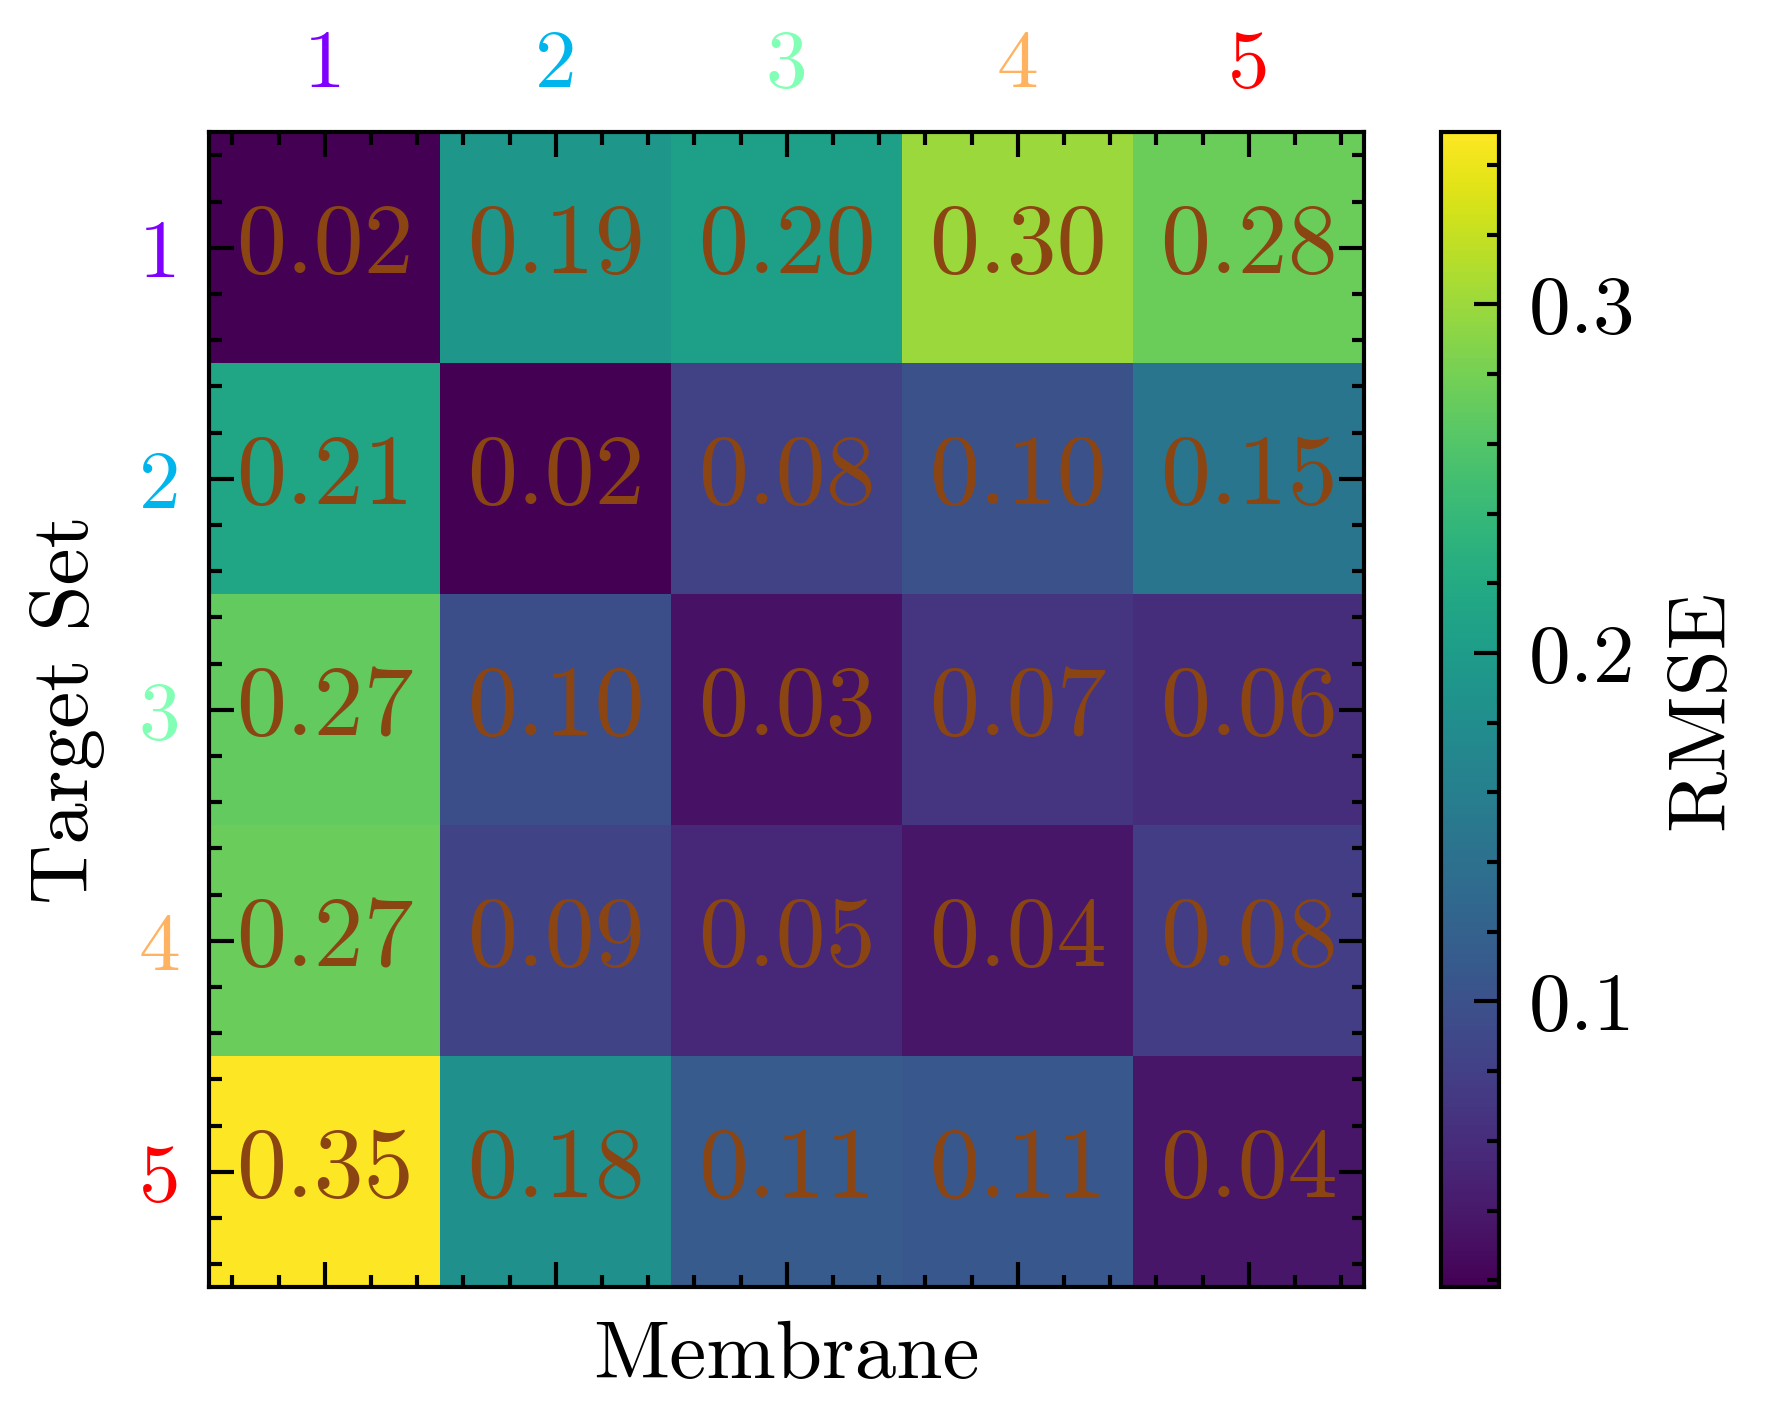

In [45]:
with plt.style.context(['science','ieee','no-latex']):
    # print a heatmap by rmse value in a 5x5 grid
    hm_rmse = jnp.array(rmse)
    n = len(hm_rmse)
    # hm_rmse = hm_rmse.reshape((5,5))
    fig, ax = plt.subplots()
    # use a gradient-based colormap
    # print numbers on the matrix as well
    cax = ax.matshow(hm_rmse, cmap='viridis')
    for i in range(n):
        for j in range(n):
            ax.text(i, j, f'{hm_rmse[j,i]:.2f}', ha='center', va='center', color='saddlebrown', fontdict={'fontsize': 12})
    cbar = fig.colorbar(cax)

    # change the x axis labels to match the colors in [189]
    ax.set_xticks(jnp.arange(n))
    ax.set_yticks(jnp.arange(n))
    ax.set_xticklabels(jnp.arange(1,n+1))
    ax.set_yticklabels(jnp.arange(1,n+1))

    # change tick label colors
    colors = cm.rainbow(jnp.linspace(0, 1, 5))
    ax = plt.gca()
    for tick_label, color in zip(ax.get_xticklabels(), colors):
        tick_label.set_color(color)
    for tick_label, color in zip(ax.get_yticklabels(), colors):
        tick_label.set_color(color)

    # Add title and labels
    cbar.set_label('RMSE')
    ax.set_xlabel('Membrane')
    ax.set_ylabel('Target Set')
    
    plt.show()


## Membrane compare.

Membrane: [2.0, 27.98, 45.58, 5.0, 60.29, 6.71]


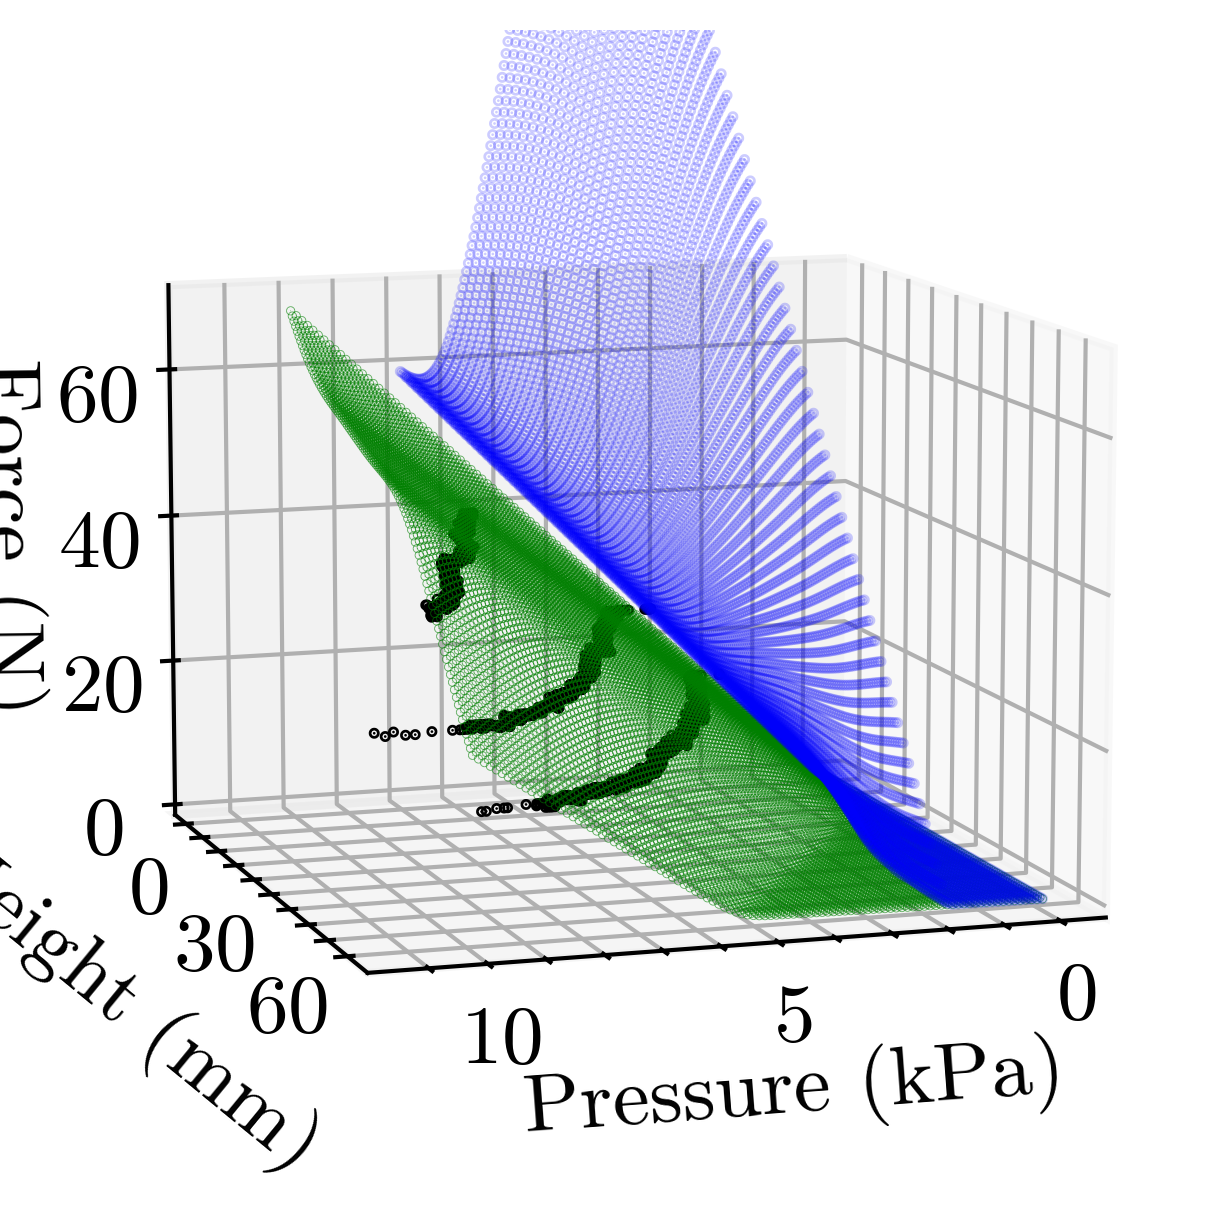

In [ ]:
Membrane_3_Pa = jnp.array( [[0.3156 ,0.7035, 0.8847],
 [0.4988 ,0.8856 ,1.0768],
 [0.7721 ,1.1348 ,1.3457]])*PSI_to_Pa #Pa

test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences - mm
test_F = [14.715, 24.525, 39.24] # N

targ_ind = 3

with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot blue plane
    blue_num = 2
    trim = 80
    trim_p = jnp.concatenate([p_model[100*i:100*i+trim] for i in range(100)])
    trim_h = jnp.concatenate([h_model[100*i:100*i+trim] for i in range(100)])
    trim_F = jnp.concatenate([flat_Fs[blue_num][100*i:100*i+trim] for i in range(100)])

    ax.scatter(trim_p/1000, trim_h, trim_F, s=0.1, c='b', alpha=0.2, marker='o', label = 'Training Plane')

    # # plot target points
    # for i in range(len(test_h)):
    #     if i == 0:
    #         ax.scatter(Membrane_3_Pa[i]/1000, test_h[i], test_F[i], c='g', s=15, alpha=1, marker='o', label = 'Target Points')
    #     else:
    #         ax.scatter(Membrane_3_Pa[i]/1000, test_h[i], test_F[i], c='g', s=15, alpha=1, marker='o')

    # plot the actual lifts
    key = list(all_lift_dict.keys())[targ_ind]
    height = jnp.array([x[0] for x in all_lift_dict[key][0][0]])
    pressure = jnp.array([x[0] for x in all_lift_dict[key][0][1]])
    force = jnp.array([x[0] for x in all_lift_dict[key][1]])

    ax.scatter(pressure/1000, height, force, c='k', s=0.1, alpha=1, marker='o', label = 'Target Lifts')

    extra_planes = 5

    # for ind in range(extra_planes):
    for ind in [targ_ind]:

        # plot the planes
        color = str(0.1+ind*0.05)
        alph = 0.4
        if ind == targ_ind:
            color = 'g'
            alph = 0.6
            ax.scatter(p_model/1000, h_model, test_Fs[ind].tolist(), s = 0.01, alpha=alph, c=color, marker='o', label = 'Optimal Plane')    
        else:
            ax.scatter(p_model/1000, h_model, test_Fs[ind].tolist(), s = 0.01, alpha=alph, c=color, marker='o')
        # mem ID
        print(f'Membrane: {list(all_lift_dict.keys())[ind]}')

    ax.view_init(elev=10, azim=72)
    # ax.view_init(elev=10, azim=-30)
    ax.set_zlim([0, 70])
    pad = -5
    ax.tick_params(axis='x', pad=pad+1)
    # less y ticks
    ax.set_yticks([0, 30, 60])
    ax.tick_params(axis='y', pad=pad+1)
    ax.tick_params(axis='z', pad=pad+3)
    ax.set_xlabel('Pressure (kPa)', labelpad=pad-2)
    ax.set_ylabel('Height (mm)', labelpad=pad-2)
    ax.set_zlabel('Force (N)', labelpad=pad-2)
    # put legend points on right side of words
    # ax.legend(loc='upper right', markerfirst=False)
    # save
    plt.savefig('membrane_planes_fig.png')
    plt.show()

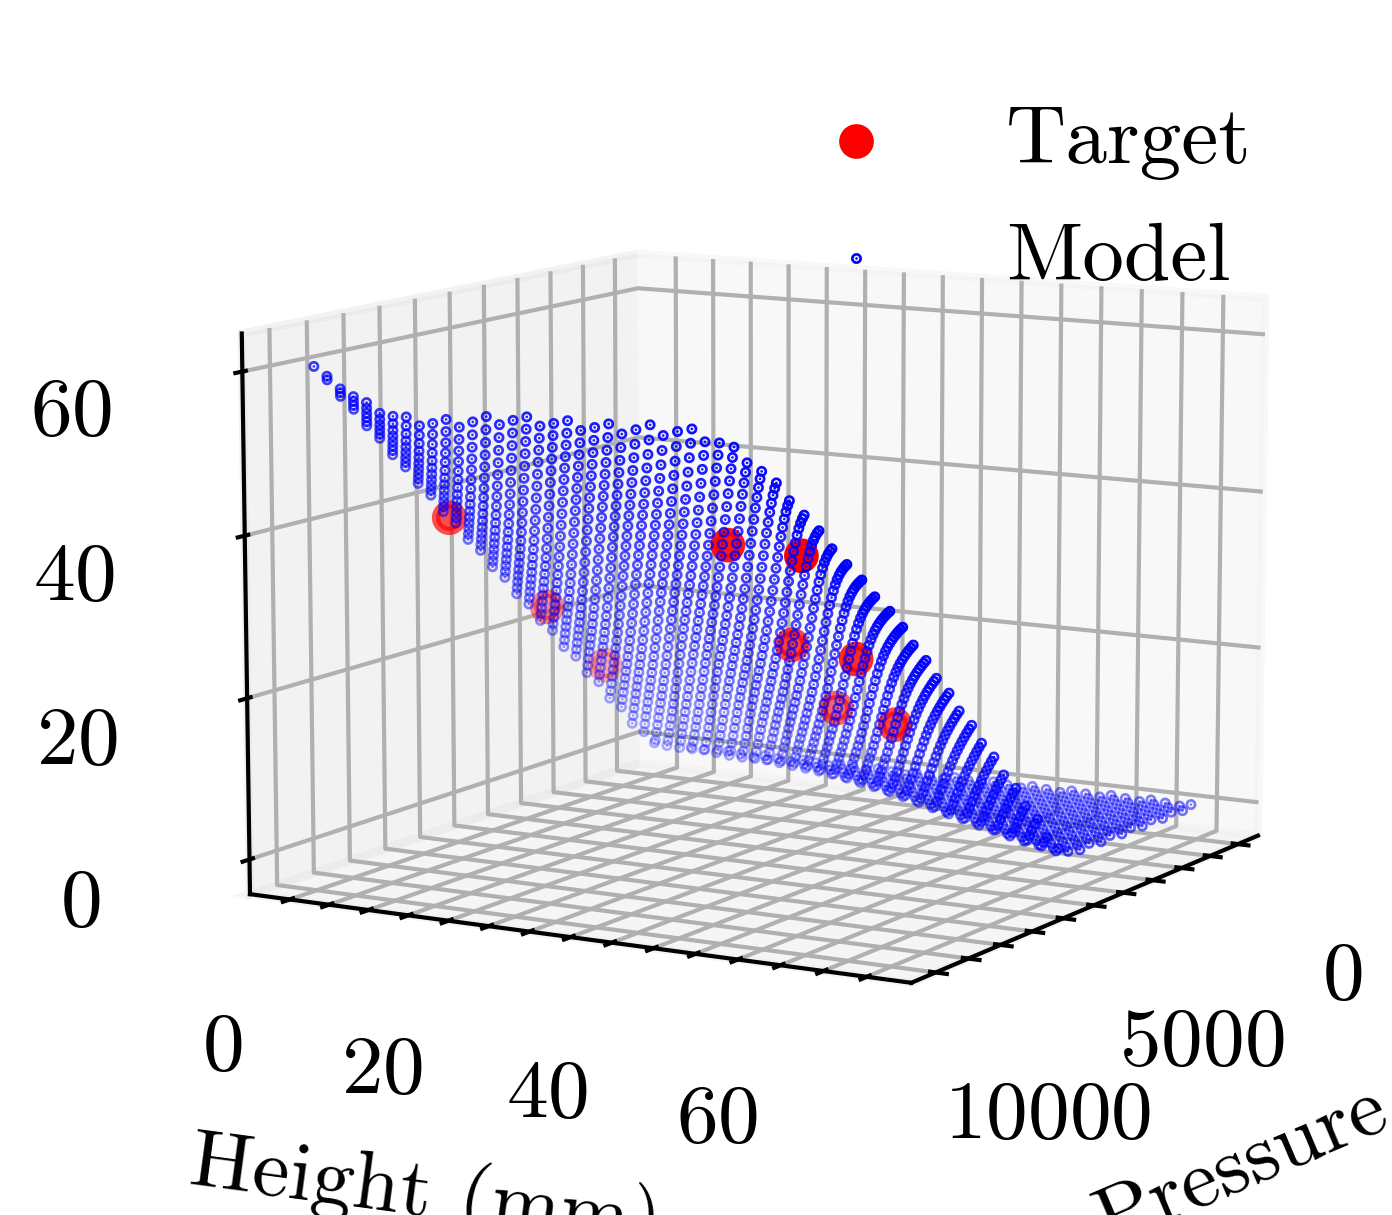

In [ ]:
# choose some target points
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences
test_F = [14.715, 24.525, 39.24]
test_p = jnp.array([[0.3952, 0.5817, 0.6834],  [0.6478, 0.7839, 0.8618],  [1.0586, 1.0654, 1.1054]])*PSI_to_Pa

# flatten the test points
test_h_flat = test_h.flatten()
test_F_flat = jnp.array([jnp.repeat(f, 3) for f in test_F]).flatten()
test_p_flat = jnp.array(test_p).flatten()

mem_deets = jnp.array([ 2.  , 25.4 , 49.  ,  5.  , 62.  ,  5.  ])

flat_out = []
# solve for the model predictions
F1s = apply_model([mem_deets],0,height_range,pressures, model)
flat_out = F1s.flatten() # N

subsample = 7

# plot the model predictions
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(test_p_flat, test_h_flat, test_F_flat, c='r', s=10, marker='o')
    ax.scatter(p_model[::subsample], h_model[::subsample], flat_out[::subsample], c='b', s = 0.1, marker='o')
    ax.set_xlabel('Pressure (Pa)')
    ax.set_ylabel('Height (mm)')
    ax.set_zlabel('Force (N)')
    plt.legend(['Target', 'Model'])
    # change the view angle
    ax.view_init(elev=10, azim=30)

    plt.show()



In [ ]:
'''
Takes: completed plot (axs), and a boolean to save the plot as a gif
Returns: a list of frames if save is True (can be used to create a gif with imageio.mimsave)
'''
def plot_spin(axs, save = False):
    frames = []
    for angle in range(0, 360 + 1):
        # Normalize the angle to the range [-180, 180] for display
        angle_norm = (angle + 180) % 360 - 180

        # Cycle through a full rotation of azimuth
        elev = 30
        azim = roll = 0
        azim = angle_norm

        # Update the axis view and title
        for ax in axs:
            ax.view_init(elev, azim, roll)
        # plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

        if save:
            plt.savefig(f'frame_temp.png')
            frames.append(imageio.v3.imread(f'frame_temp.png'))
        else:
            plt.draw()
            plt.pause(.001)
    if save:
        return frames

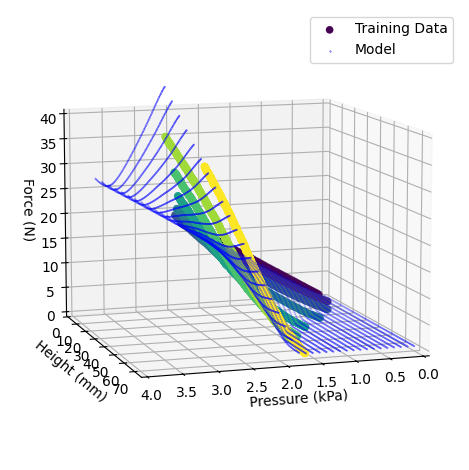

In [46]:
# make a spin graph comparing model to characerization data
# choose an example membrane to plot
j = 2
trim = 37 # contain data to z-limits of training data 
key = list(new_dict.keys())[j]
height = jnp.array([x[0] for x in new_dict[key][0][0]])
pressure = jnp.array([x[0] for x in new_dict[key][0][1]])
force = jnp.array([x[0] for x in new_dict[key][1]])

trim_p = jnp.concatenate([p_model[100*i:100*i+trim] for i in range(100)])
trim_h = jnp.concatenate([h_model[100*i:100*i+trim] for i in range(100)])
trim_F = jnp.concatenate([flat_Fs[j][100*i:100*i+trim] for i in range(100)])

# with plt.style.context(['science','ieee','no-latex']):
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pressure/1000, height, force, c=height, marker='o')
# ax.scatter(p_model[:trim], h_model[:trim], flat_Fs[j][:trim], s=0.1, c='b', marker='o')
ax.scatter(trim_p/1000, trim_h, trim_F, s=0.1, c='b', marker='o')


# change the view angle
# ax.view_init(elev=10, azim=-30)
ax.view_init(elev=10, azim=72)
# ax.view_init(elev = 30, azim = 0)
# set axis limits based on pressure, height, force
ax.set_xlim([0, 4])
ax.set_ylim([0, 75])
# ax.set_ylim([60, 0])
ax.set_zlim([0, 40])
# tighten up to axis
pad = -2
ax.tick_params(axis='x', pad=pad+1)
ax.tick_params(axis='y', pad=pad+2)
ax.tick_params(axis='z', pad=pad+2)
ax.set_xlabel('Pressure (kPa)', labelpad=pad)
ax.set_ylabel('Height (mm)', labelpad=pad)
ax.set_zlabel('Force (N)', labelpad=pad)
plt.tight_layout()
plt.legend(['Training Data', 'Model'], loc='upper right')
plt.show()    
# frames = plot_spin([ax], save = True)
# imageio.mimsave('mem_{j}_compare.gif', frames, fps = 30, loop = 0)


### Show ensemble discorse

In [56]:
# make plots with a std of values included
h_num = 40
p_num = int(num_test)

simple_h = jnp.linspace(0, 70, h_num)[:,None] #mm
p_min = 0.01 #Pa
p_max = 10_000 #Pa
pressures = jnp.linspace(p_min, p_max, p_num)[:,None]


choice_mem = jnp.array([ 2.  , 25.4 , 37.  ,  7.5  , 55.  ,  5.  ])
# choice_mem = In_mem[1]


h_len = len(simple_h)
p_len = len(pressures)

print(f'len: {h_len}, {p_len}')
# Ensure membrane is a (h_len,6) matrix
membrane_matrix = jnp.tile(choice_mem, (simple_h.shape[0], 1))
# Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
u = jnp.hstack((simple_h, membrane_matrix))
Fs = jnp.zeros((h_len, p_len)) #lbf
low_Fs = jnp.zeros((h_len, p_len))
high_Fs = jnp.zeros((h_len, p_len))
num_low = jnp.zeros((h_len, p_len))

# TODO - make vector of h into a matrix, make vector of p into a matrix, apply model to all values at once
for i in range(h_len):
    pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), pressures)
    pred = nn.relu(pred)
    Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
    low_Fs = low_Fs.at[i,:].set(pred.min(0).squeeze())
    high_Fs = high_Fs.at[i,:].set(pred.max(0).squeeze())
    # print(pred[:,-1] < 1)
    num_low = num_low.at[i,:].set(jnp.sum(pred[:,-1] < 1, axis=0).squeeze())

std_rdy_h = jnp.repeat(simple_h, len(pressures)) #mm
std_rdy_p = jnp.tile(pressures, h_len).flatten('F') # Pa
std_rdy_F = Fs.flatten() # N
std_rdy_low = low_Fs.flatten()
std_rdy_high = high_Fs.flatten()
std_rdy_num = num_low.flatten()

print(f'lens: {len(std_rdy_F)}, {len(std_rdy_p)}, {len(std_rdy_h)}')

len: 40, 100
lens: 4000, 4000, 4000


In [57]:
# Spin graphic of uncertainty quantification

mems = [[ 2.  , 27 , 37.  ,  7.5  , 55.  ,  5.  ], 
        [ 1.  , 25.4 , 37.  ,  5.  , 60.  ,  7.  ], [1., 26, jnp.nan, jnp.nan, jnp.nan, jnp.nan],
        [ 1.  , 30 , 38  ,  5.  , 52.  ,  5.  ], [ 1.  , 25.4 , 37.  ,  5.  , 60.  ,  7.  ],
        [3., 33, jnp.nan, jnp.nan, jnp.nan, jnp.nan]]

highs = []
lows = []
means = []

h_num = 40

simple_h = jnp.linspace(0, 70, h_num)[:,None] #mm
p_min = 0.01 #Pa
p_max = 10_000 #Pa
pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

std_rdy_h = jnp.repeat(simple_h, len(pressures)) #mm
std_rdy_p = jnp.tile(pressures, len(simple_h)).flatten('F') # Pa

for choice_mem in mems:
    choice_mem = jnp.array(choice_mem)
    # Ensure membrane is a (h_len,6) matrix
    membrane_matrix = jnp.tile(choice_mem, (simple_h.shape[0], 1))
    # Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
    u = jnp.hstack((simple_h, membrane_matrix))
    Fs = jnp.zeros((h_num, p_len)) #lbf
    low_Fs = jnp.zeros((h_num, p_len))
    high_Fs = jnp.zeros((h_num, p_len))

    # TODO - make vector of h into a matrix, make vector of p into a matrix, apply model to all values at once
    for i in range(h_num):
        pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), pressures)
        pred = nn.relu(pred)
        Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
        low_Fs = low_Fs.at[i,:].set(pred.min(0).squeeze())
        high_Fs = high_Fs.at[i,:].set(pred.max(0).squeeze())


    std_rdy_F = Fs.flatten() # N
    std_rdy_low = low_Fs.flatten()
    std_rdy_high = high_Fs.flatten()
    highs.append(std_rdy_high)
    lows.append(std_rdy_low)
    means.append(std_rdy_F)

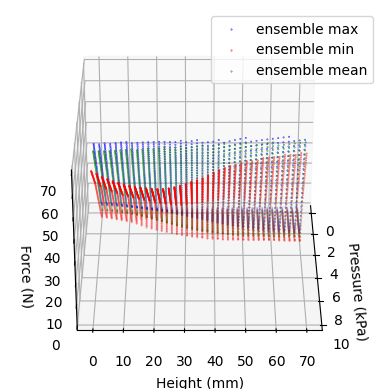

In [58]:
num_plane = len(highs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# start with something similar to spin_function
frames = []
spin_angle = 270
for angle in range(0, spin_angle + 91):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # clear the axis
    ax.clear()
    
    # plot the planes
    if angle > 0:
        ind = (angle-1)*num_plane//spin_angle
        if ind >= num_plane: # stay on last plane for additional rotation
            ind = num_plane-1
    else:
        ind = 0

    color = 'grey'

    this_high = jnp.where(highs[ind] > z_lim, jnp.nan, highs[ind])
    this_low = jnp.where(lows[ind] > z_lim, jnp.nan, lows[ind])
    this_mean = jnp.where(means[ind] > z_lim, jnp.nan, means[ind])

    # make the correct plane come last.
    ax.scatter(std_rdy_p/1000, std_rdy_h, this_high, c='b', s=.1, marker='o', label = 'ensemble max')
    ax.scatter(std_rdy_p/1000, std_rdy_h, this_low, c='r', s=.1, marker='o', label = 'ensemble min')
    ax.scatter(std_rdy_p/1000, std_rdy_h, this_mean, c='g', s=.1, marker='o', label = 'ensemble mean')

    # Cycle through a full rotation of azimuth
    elev = 30
    azim = roll = 0
    azim = angle_norm

    # set z_lim to 70
    ax.set_zlim([0, 70])

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    
    # plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    ax.set_xlabel('Pressure (kPa)')
    ax.set_ylabel('Height (mm)')
    ax.set_zlabel('Force (N)')
    ax.legend(loc = 'upper right')
    # plt.savefig(f'frame_temp.png')
    # frames.append(imageio.v3.imread(f'frame_temp.png'))

plt.show()
# Save the frames as a gif
# imageio.mimsave('membrane_uncertainty_flash.gif', frames, fps=30, loop=0)